# seaborn.objects Recipes

In [2]:
# Pandas
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

# Seaborn.objects
import seaborn.objects as so
import seaborn as sns

# Statsmodels for regressions
import statsmodels.formula.api as smf

# Filter out FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Get Penguins Dataset
penguins = sns.load_dataset("penguins")

## Regression with Confidence Intervals


In [3]:
def plot_regression_w_ci(data, yvar, xvar, alpha=0.05, dots=True):
    """
    Returns a seaborn.objects scatter plot with Dots and a linear
    regression with confidence intervals.

    :param alpha: Confidence inteval alpha.
    :param dots: Should data points be included in plot?
    """

    # missings get dropped before `model` object created
    # also `model_predict` ends up with new index, causing index
    # issues if rows change. So...
    data = data[pd.notnull(data[yvar]) & pd.notnull(data[xvar])].reset_index()

    # Fit model
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()

    # Get predicted values
    model_predict = model.get_prediction(data[xvar])
    data["predicted_" + yvar] = model_predict.summary_frame()["mean"]
    data[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Make plot.
    plot = so.Plot(data, x=xvar)

    if dots:
        plot = plot.add(so.Dots(), y=yvar)

    # Add overlay later so y-var name is from dots.
    plot = plot.add(so.Lines(), y="predicted_" + yvar).add(
        so.Band(), ymin="ci_low", ymax="ci_high"
    )

    return plot

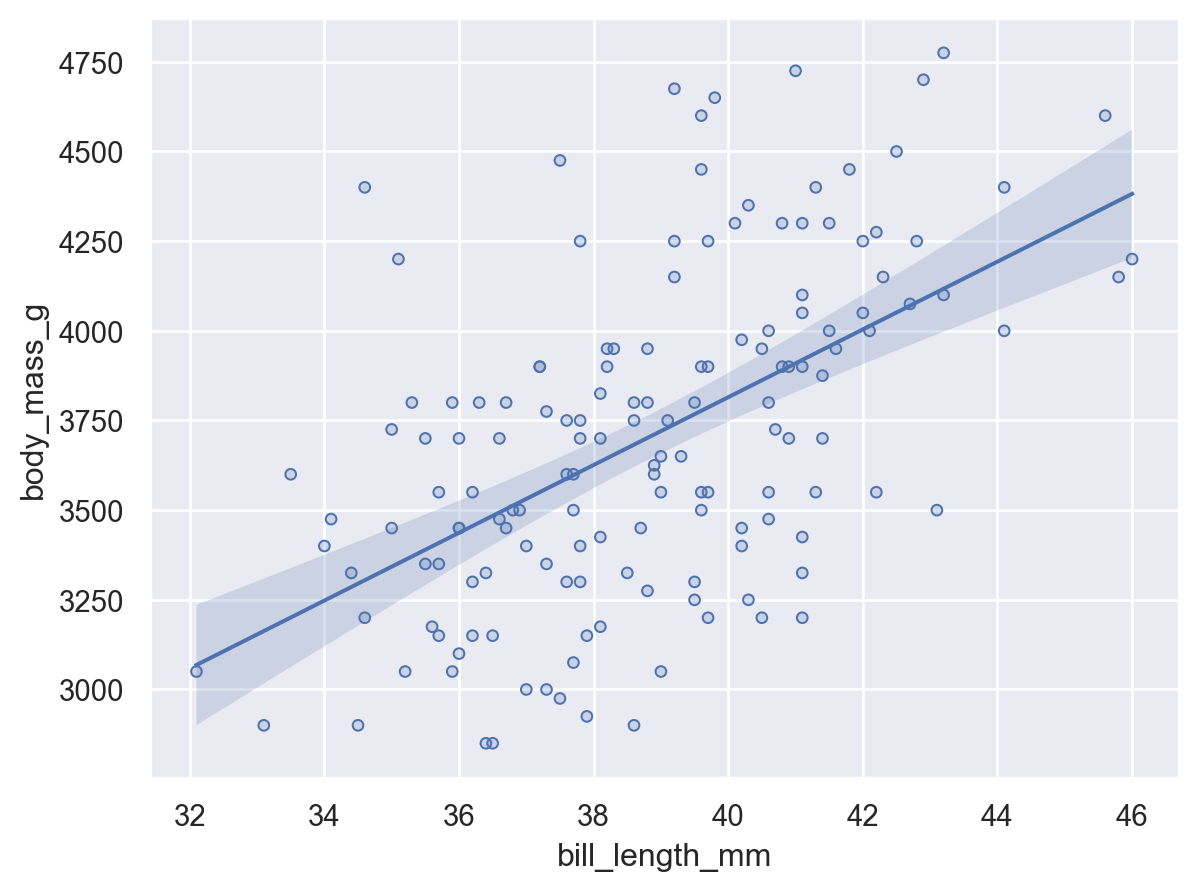

In [4]:
plot_regression_w_ci(
    penguins[penguins.species == "Adelie"], xvar="bill_length_mm", yvar="body_mass_g"
)

In [13]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from seaborn._stats.base import Stat
import statsmodels.api as sm


@dataclass
class Lowess(Stat):
    """
    Fit a locally-weighted regression to smooth the data.
    """

    frac: float = 0.2  # Fraction of data to use when estimating each y-value
    gridsize: int = 100  # How fine-grained to plot the curve. Increase if jagged.

    def _fit_predict(self, data):
        x = data["x"]
        xx = np.linspace(x.min(), x.max(), self.gridsize)
        # https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
        yy = sm.nonparametric.lowess(exog=x, endog=data["y"], xvals=xx, frac=self.frac)
        return pd.DataFrame(dict(x=xx, y=yy))

    def __call__(self, data, groupby, orient, scales):
        return groupby.apply(data.dropna(subset=["x", "y"]), self._fit_predict)

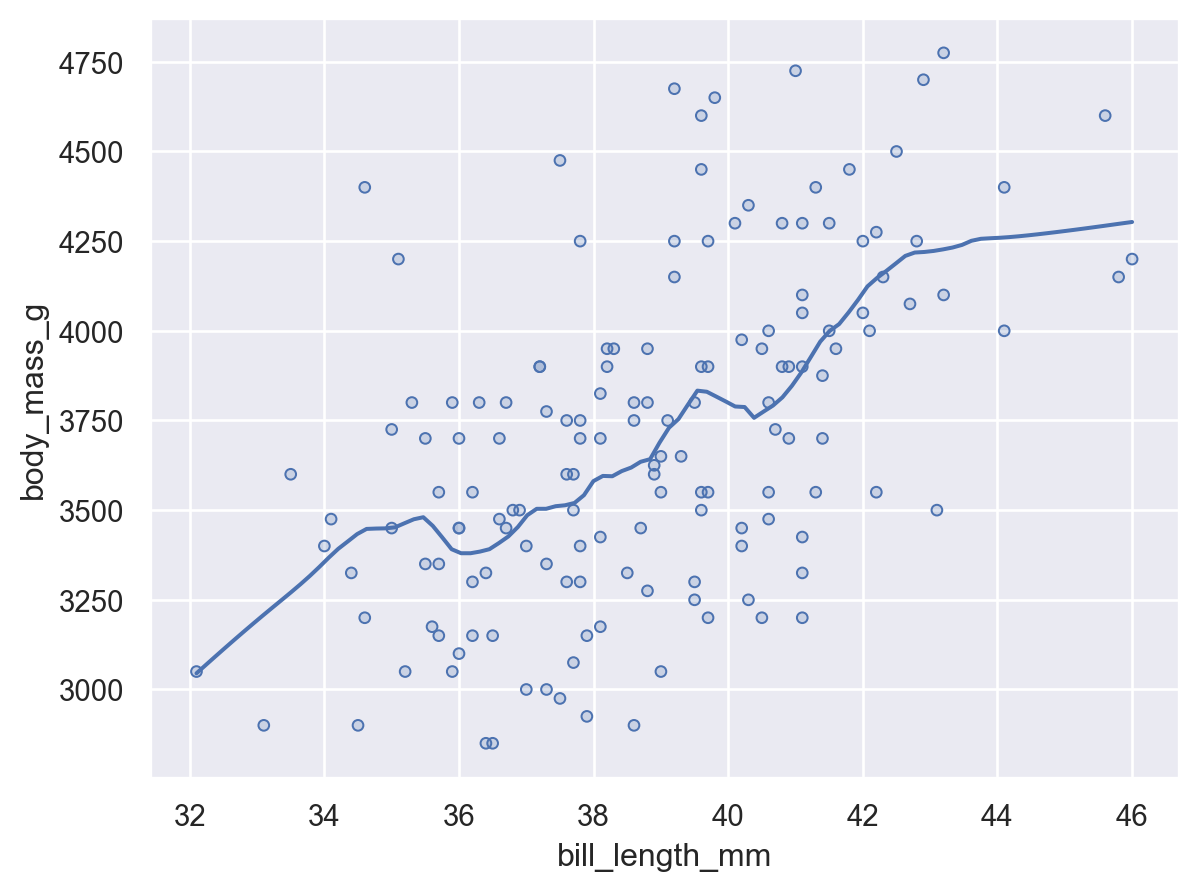

In [17]:
(
    so.Plot(penguins[penguins.species == "Adelie"], x="bill_length_mm", y="body_mass_g")
    .add(so.Dots())
    .add(so.Line(), Lowess())
)